# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

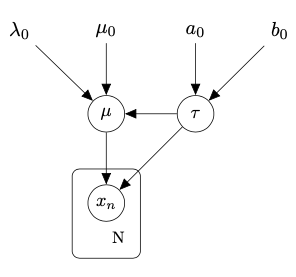

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [37]:
import numpy as np
import numpy.random as np_rand
import matplotlib.pyplot as plt
import scipy.special as sp_spec
from scipy.stats import norm as norm
from scipy.stats import gamma as gamma
np.random.seed(345)

In [38]:
# Generate datapoints that have a normal distribution with mean mu and precision tau
def generate_data(mu, tau, N):
  data = np_rand.normal(mu, 1/np.sqrt(tau), N)
  return data


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



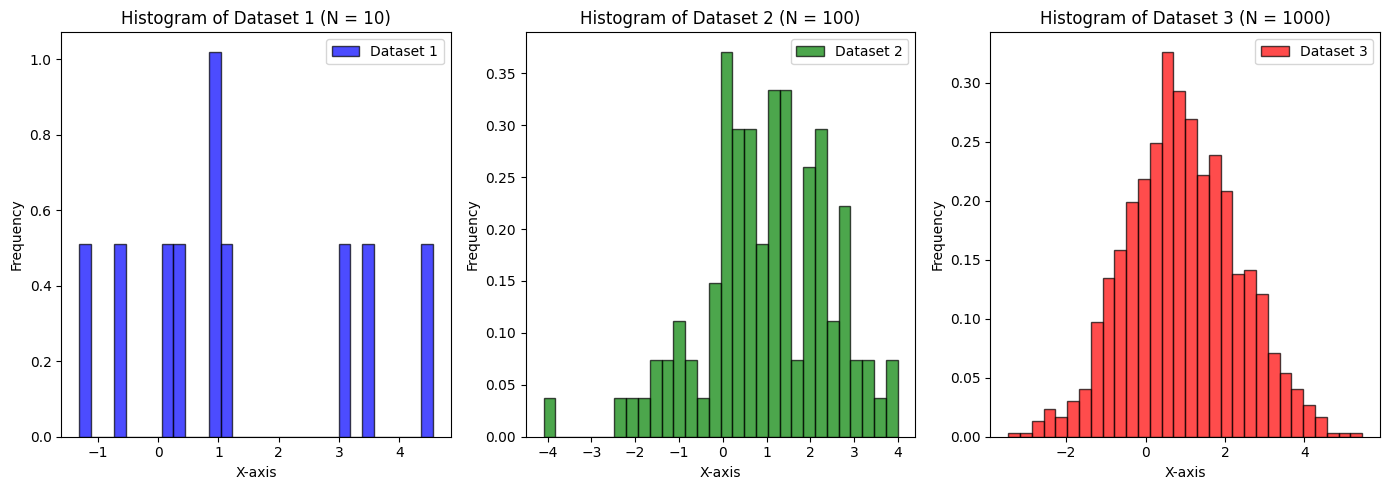

In [39]:
# generate data
mu, tau = 1, 0.5
dataset_1 = generate_data(mu, tau, 10) # N = 10
dataset_2 = generate_data(mu, tau, 100) # N = 100
dataset_3 = generate_data(mu, tau, 1000) # N = 1000


fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Plot histogram for dataset 1
axs[0].hist(dataset_1, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black', label='Dataset 1')
axs[0].set_title('Histogram of Dataset 1 (N = 10)')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Plot histogram for dataset 2
axs[1].hist(dataset_2, bins=30, density=True, alpha=0.7, color='green', edgecolor='black', label='Dataset 2')
axs[1].set_title('Histogram of Dataset 2 (N = 100)')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Plot histogram for dataset 3
axs[2].hist(dataset_3, bins=30, density=True, alpha=0.7, color='red', edgecolor='black', label='Dataset 3')
axs[2].set_title('Histogram of Dataset 3 (N = 1000)')
axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
#plt.savefig('../Images/histograms.png')
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [40]:
def ML_est(data):
  N = data.shape[0]
  mu_ml = np.mean(data)
  tau_ml = N/np.sum((data - mu_ml)**2)
  return mu_ml, tau_ml

# Printing ML mean and precision estimates for each dataset
print('Mean and precision for dataset 1: ', ML_est(dataset_1))
print('Mean and precision for dataset 2: ', ML_est(dataset_2))
print('Mean and precision for dataset 3: ', ML_est(dataset_3))

Mean and precision for dataset 1:  (1.266028105946296, 0.3144166580382695)
Mean and precision for dataset 2:  (1.004280422073872, 0.48794889952614123)
Mean and precision for dataset 3:  (0.9343529824279556, 0.5157473861094543)


The more the number of datapoints increases, the closer we get to the real values of parameters $\mu$ and $\tau$.

### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [41]:
# prior parameters
mu_0 = 1
lambda_0 = 10
a_0 = 10
b_0 = 20

Continue with a helper function that computes ELBO:


In [42]:
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here (up to a constant)

  # computing useful expectation value (given the distribution q(mu, tau))
  E_tau = a_N / b_N
  E_mu2 = 1/lambda_N + mu_N**2
  E_log_tau = sp_spec.digamma(a_N) - np.log(b_N)

  # computing entropies
  entropy_q = norm.entropy(loc=mu_N, scale=1/np.sqrt(lambda_N))
  entropy_tau = gamma.entropy(a_N, scale=1/b_N)

  # computing the data terms
  data_sum = np.sum(D)
  data_square_sum = np.sum(D**2)
  N = D.shape[0]

  # computing the ELBO
  elbo = - E_tau * (b_0 + lambda_0 * ( E_mu2 - 2 * mu_0 * mu_N + mu_0**2) / 2) \
    -(1/2) * E_tau * (data_square_sum - 2 * data_sum * mu_N + N * E_mu2) \
    + (a_0 - 1/2 + N/2)*E_log_tau \
    + entropy_q + entropy_tau
  """
  elbo = - E_tau * (b_0 + lambda_0 * ( E_mu2 - 2 * mu_0 * mu_N + mu_0**2)) \
    -(1/2) * E_tau * (data_square_sum - 2 * data_sum * mu_N + N * E_mu2) \
    + (a_0 - 1/2 + N/2)*E_log_tau \
    + entropy_q + entropy_tau
  """


  return elbo


Now, implement the CAVI algorithm:

In [43]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, n_iter):
  N = len(D)
  E_tau = 1 #we use the ML estimate of tau as its first expectation guess

  elbo_list = []
  a_N_list = []
  b_N_list = []
  mu_N_list = []
  lambda_N_list = []


  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence

  for i in range(n_iter):
    # updating the parameters of mu
    mu_N = (lambda_0 * mu_0 + N * D.mean()) / (lambda_0 + N)
    lambda_N = (lambda_0 + N) * E_tau

    # updating the parameters of tau

    ### computing useful expectations and data terms
    E_mu = mu_N
    E_mu2 = 1/lambda_N + mu_N**2
    data_sum = np.sum(D)
    data_square_sum = np.sum(D**2)

    ### updating the parameters
    a_N = a_0 + (N+1)/2
    b_N = b_0 + 0.5 * (data_square_sum + lambda_0*mu_0**2 - 2*(data_sum + lambda_0*mu_0)*E_mu + (N+lambda_0)*E_mu2)
    E_tau = a_N / b_N

    # saving the parameters
    a_N_list.append(a_N)
    b_N_list.append(b_N)
    mu_N_list.append(mu_N)
    lambda_N_list.append(lambda_N)

    i += 1 #iteration counter
    elbo_list.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N))

  return a_N_list, b_N_list, mu_N_list, lambda_N_list, elbo_list

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [44]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  N = len(D)

  # computing parameters of the posterior Normal-Gamma distribution
  a_star = a_0 + (N-1)/2
  b_star = b_0 + 0.5 * (np.sum(D**2) + lambda_0*mu_0**2 - (np.sum(D) + lambda_0*mu_0)**2/(N+lambda_0))
  lambda_star = lambda_0 + N
  mu_star = (lambda_0 * mu_0 + np.sum(D)) / (lambda_0 + N)

  return a_star, b_star, mu_star, lambda_star

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



In [45]:
# number of iterations
n_iter = 4

# Comparing the exact posterior with the CAVI approximation
a_star_1, b_star_1, mu_star_1, lambda_star_1 = compute_exact_posterior(dataset_1, a_0, b_0, mu_0, lambda_0)
a_0_list_1, b_0_list_1, mu_0_list_1, lambda_0_list_1, elbo_list_1 = CAVI(dataset_1, a_0, b_0, mu_0, lambda_0, n_iter)

a_star_2, b_star_2, mu_star_2, lambda_star_2 = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
a_0_list_2, b_0_list_2, mu_0_list_2, lambda_0_list_2, elbo_list_2 = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0, n_iter)

a_star_3, b_star_3, mu_star_3, lambda_star_3 = compute_exact_posterior(dataset_3, a_0, b_0, mu_0, lambda_0)
a_0_list_3, b_0_list_3, mu_0_list_3, lambda_0_list_3, elbo_list_3 = CAVI(dataset_3, a_0, b_0, mu_0, lambda_0, n_iter)

# Printing the parameters of the exact posterior and the CAVI approximation
print('Exact posterior parameters for dataset 1: ', round(a_star_1, 2), round(b_star_1, 2), round(mu_star_1, 2), round(lambda_star_1, 2))
print('CAVI parameters for dataset 1: ', round(a_0_list_1[-1], 2), round(b_0_list_1[-1], 2), round(mu_0_list_1[-1], 2), round(lambda_0_list_1[-1], 2), '\n\n')

print('Exact posterior parameters for dataset 2: ', round(a_star_2, 2), round(b_star_2, 2), round(mu_star_2, 2), round(lambda_star_2, 2))
print('CAVI parameters for dataset 2: ', round(a_0_list_2[-1], 2), round(b_0_list_2[-1], 2), round(mu_0_list_2[-1], 2), round(lambda_0_list_2[-1], 2), '\n\n')

print('Exact posterior parameters for dataset 3: ', round(a_star_3, 2), round(b_star_3, 2), round(mu_star_3, 2), round(lambda_star_3, 2))
print('CAVI parameters for dataset 3: ', round(a_0_list_3[-1], 2), round(b_0_list_3[-1], 2), round(mu_0_list_3[-1], 2), round(lambda_0_list_3[-1], 2), '\n\n')


Exact posterior parameters for dataset 1:  14.5 36.08 1.13 20
CAVI parameters for dataset 1:  15.5 37.28 1.13 8.32 


Exact posterior parameters for dataset 2:  59.5 122.47 1.0 110
CAVI parameters for dataset 2:  60.5 123.49 1.0 53.89 


Exact posterior parameters for dataset 3:  509.5 989.49 0.94 1010
CAVI parameters for dataset 3:  510.5 990.46 0.94 520.57 




In [46]:
def plot_contour_plots(dataset, ax, X, Y) :
    a_N_list, b_N_list, mu_N_list, lambda_N_list, elbo_list = CAVI(dataset, a_0, b_0, mu_0, lambda_0, n_iter)
    a_star, b_star, mu_star, lambda_star = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)

    # Contour plot of the true posterior
    true_posterior = norm.pdf(X, loc=mu_star, scale=np.sqrt(1 / (lambda_star * Y))) \
        * gamma.pdf(Y, a_star, scale=1 / b_star)

    ax[0].contour(X, Y, true_posterior, 5, colors='green', alpha=0.5)
    ax[1].contour(X, Y, true_posterior, 5, colors='green', alpha=0.5)
    ax[2].contour(X, Y, true_posterior, 5, colors='green', alpha=0.5)


    for i in range(0, 3) :
        # Contour plot of the variational posterior
        variational_posterior = norm.pdf(X, loc=mu_N_list[-i-1], scale=np.sqrt(1 / (lambda_N_list[-i-1]))) \
                                * gamma.pdf(Y, a_N_list[-i-1], scale=1 / b_N_list[-i-1])

        ax[-i-1].contour(X, Y, variational_posterior, 5, colors='red', alpha=0.5)

        ax[-i-1].set_xlabel(r'$\mu$')
        ax[-i-1].set_ylabel(r'$\tau$')


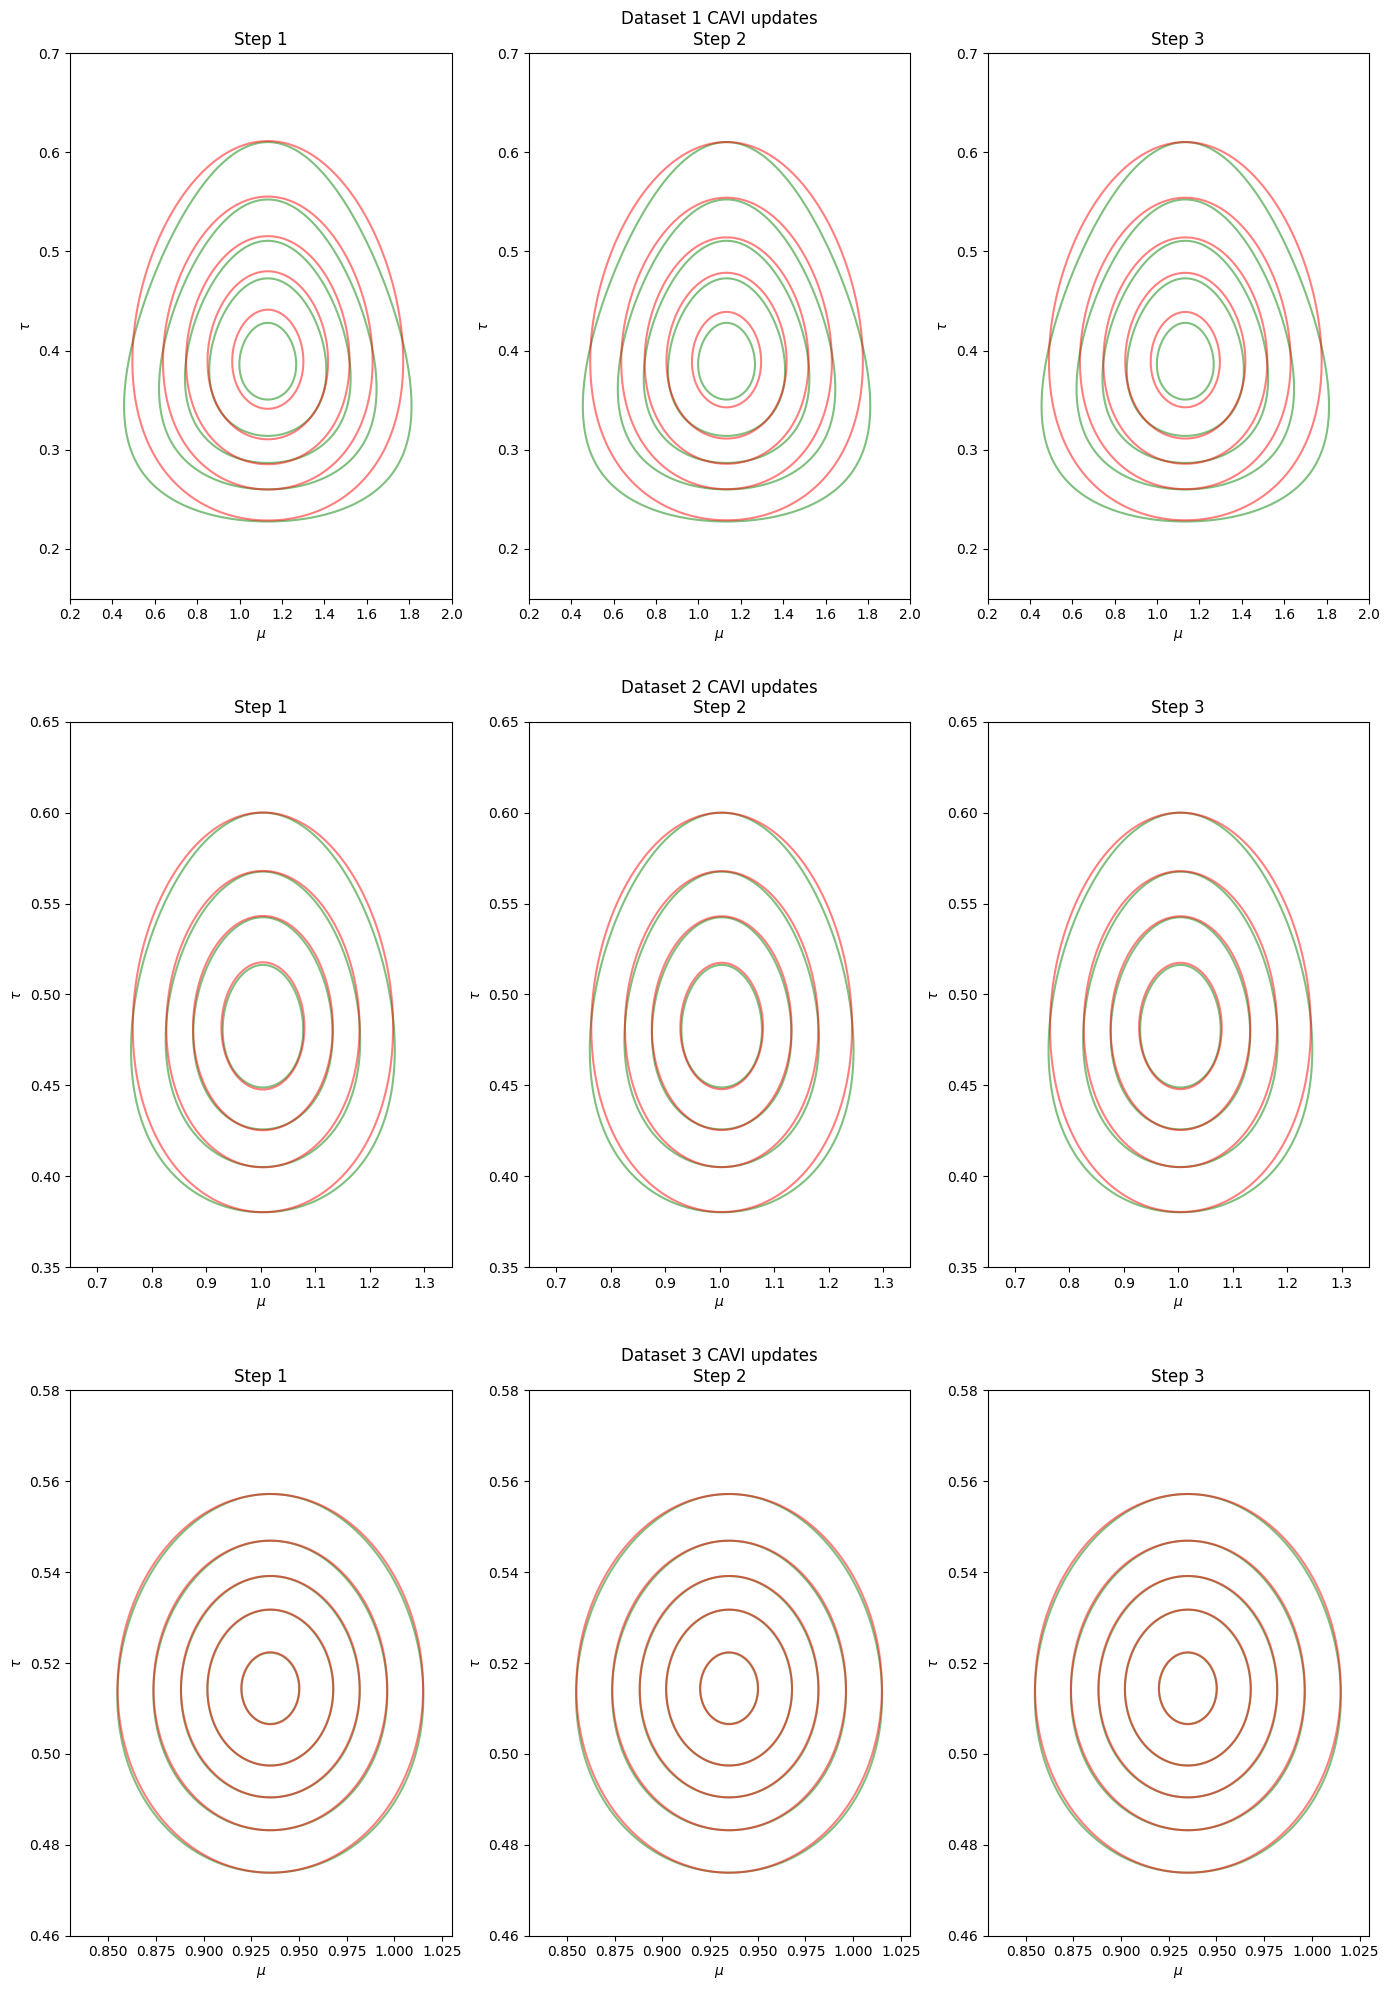

In [47]:
# Plotting the contour plots of the true posterior and the approximated posterior
# for the three first steps of CAVI,
# for each dataset?

fix, axs = plt.subplots(3, 3, figsize=(14, 20))

# Create a grid of x and y values for each dataset
mu_1 = np.linspace(0.2, 2, 1000)
tau_1 = np.linspace(0.15, 0.7, 1000)
MU_1, TAU_1 = np.meshgrid(mu_1, tau_1)

mu_2 = np.linspace(0.65, 1.35, 1000)
tau_2 = np.linspace(0.35, 0.65, 1000)
MU_2, TAU_2 = np.meshgrid(mu_2, tau_2)

mu_3 = np.linspace(0.83, 1.03, 1000)
tau_3 = np.linspace(0.46, 0.58, 1000)
MU_3, TAU_3 = np.meshgrid(mu_3, tau_3)

# Plotting the contour plots for each dataset
plot_contour_plots(dataset_1, axs[0], MU_1, TAU_1)
plot_contour_plots(dataset_2, axs[1], MU_2, TAU_2)
plot_contour_plots(dataset_3, axs[2], MU_3, TAU_3)

axs[0,0].set_title('\nStep 1')
axs[0,1].set_title('Dataset 1 CAVI updates\nStep 2')
axs[0,2].set_title('\nStep 3')

axs[1,0].set_title('\nStep 1')
axs[1,1].set_title('\nDataset 2 CAVI updates\nStep 2')
axs[1,2].set_title('\nStep 3')

axs[2,0].set_title('\nStep 1')
axs[2,1].set_title('\nDataset 3 CAVI updates\nStep 2')
axs[2,2].set_title('\nStep 3')

plt.tight_layout()
plt.show()


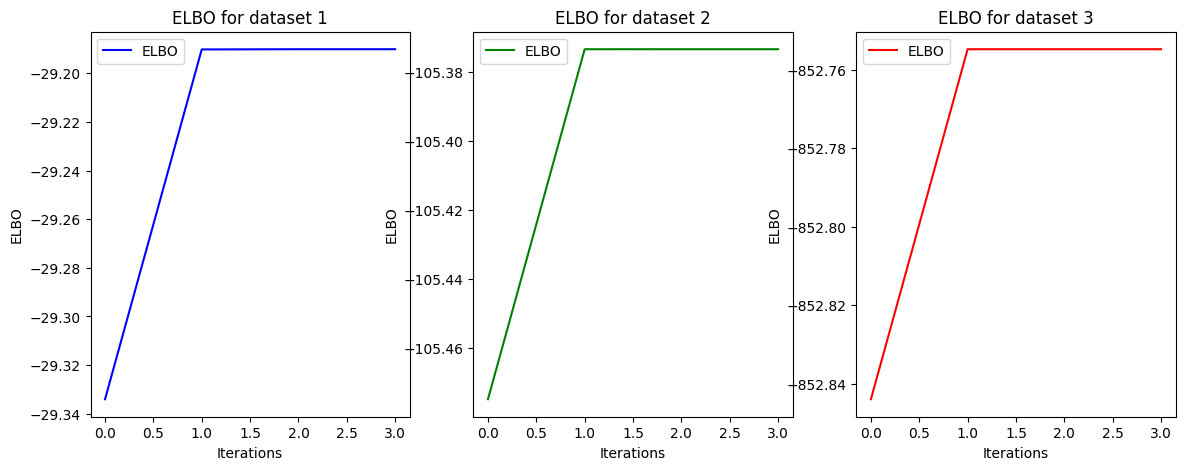

In [48]:
# Plotting the ELBO for each dataset
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

axs[0].plot(elbo_list_1, color='blue', label='ELBO')
axs[0].set_title('ELBO for dataset 1')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('ELBO')
axs[0].legend()

axs[1].plot(elbo_list_2, color='green', label='ELBO')
axs[1].set_title('ELBO for dataset 2')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('ELBO')
axs[1].legend()

axs[2].plot(elbo_list_3, color='red', label='ELBO')
axs[2].set_title('ELBO for dataset 3')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('ELBO')
axs[2].legend()

plt.show()